<a href="https://colab.research.google.com/github/AdiMendelowitz/CV-RP/blob/main/computer-vision-foundations/code/pytorch_cnn/03_resnet_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet-18 on CIFAR-10

Training ResNet-18 from scratch on CIFAR-10 using a free Colab GPU.

**Target: >85% test accuracy**

---

## Setup Instructions
1. Go to **Runtime → Change runtime type → T4 GPU**
2. Run all cells top to bottom
3. Training takes ~15-20 minutes on T4 GPU
4. Download results at the end

---

## 1. Check GPU

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
else:
    print('WARNING: No GPU found. Go to Runtime -> Change runtime type -> T4 GPU')

Device: cuda
GPU: Tesla T4
Memory: 15.6 GB


## 2. Clone Repository

In [2]:
import os

# Clone repo
!git clone https://github.com/AdiMendelowitz/CV-RP.git

# Navigate to pytorch_cnn folder
os.chdir('CV-RP/computer-vision-foundations/code/pytorch_cnn')
print(f'Working directory: {os.getcwd()}')
print(f'Files: {os.listdir()}')

Cloning into 'CV-RP'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 272 (delta 82), reused 246 (delta 56), pack-reused 0 (from 0)
Receiving objects: 100% (272/272), 482.24 KiB | 5.42 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Working directory: /content/CV-RP/week-01/code/pytorch_cnn
Files: ['cnn_pytotch.py', 'compare_implementations.py', '03_resnet_training.ipynb', 'resnet.py', 'train_cifar.py']


## 3. Architecture Overview

ResNet-18 uses **residual connections** (skip connections) to solve the vanishing gradient problem in deep networks:

```
output = F(x) + x
```

Instead of learning the full mapping, each block learns the **residual** — the difference from the identity. This allows gradients to flow directly through the network without degradation.

```
Input (3, 32, 32)
    ↓
Conv1 (3→64, 3×3)          # Smaller kernel than ImageNet version (7×7→3×3 for 32×32 input)
BN + ReLU
    ↓
Layer1: 2× BasicBlock(64)   → (64, 32, 32)
Layer2: 2× BasicBlock(128)  → (128, 16, 16)
Layer3: 2× BasicBlock(256)  → (256, 8, 8)
Layer4: 2× BasicBlock(512)  → (512, 4, 4)
    ↓
AvgPool → Flatten → Dense(512→10) → Softmax
```

## 4. Model Definition

In [3]:
import torch.nn as nn

# Import from repo
from resnet import BasicBlock, ResNet, resnet18

# Build model - adapted for CIFAR-10 (32x32 images, not 224x224)
# Key difference from ImageNet ResNet-18:
# - First conv: 3x3 instead of 7x7 (images are smaller)
# - No maxpool after first conv (would reduce 32x32 too aggressively)
class ResNet18CIFAR(nn.Module):
    """
    ResNet-18 adapted for CIFAR-10.

    Changes from standard ImageNet ResNet-18:
    - First conv: 7x7 stride 2 -> 3x3 stride 1 (preserve spatial resolution)
    - Remove initial maxpool (32x32 is already small)
    """
    def __init__(self, num_classes=10):
        super(ResNet18CIFAR, self).__init__()

        self.current_channels = 64

        # CIFAR adaptation: smaller first conv, no maxpool
        self.conv1   = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1     = nn.BatchNorm2d(64)
        self.relu    = nn.ReLU(inplace=True)
        # No maxpool here (would destroy 32x32 spatial info)

        self.layer1  = self._make_layer(BasicBlock, 64,  2, stride=1)
        self.layer2  = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3  = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4  = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512, num_classes)

        self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = [block(self.current_channels, out_channels, stride)]
        self.current_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # (batch, 64, 32, 32)
        x = self.layer1(x)                       # (batch, 64,  32, 32)
        x = self.layer2(x)                       # (batch, 128, 16, 16)
        x = self.layer3(x)                       # (batch, 256,  8,  8)
        x = self.layer4(x)                       # (batch, 512,  4,  4)
        x = self.avgpool(x)                      # (batch, 512,  1,  1)
        x = torch.flatten(x, 1)                  # (batch, 512)
        x = self.fc(x)                           # (batch, 10)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Initialize model
model = ResNet18CIFAR(num_classes=10).to(device)
print(f'Parameters: {model.count_parameters():,}')
print(f'Device: {next(model.parameters()).device}')

# Test forward pass
x = torch.randn(4, 3, 32, 32).to(device)
out = model(x)
print(f'Input:  {x.shape}')
print(f'Output: {out.shape}')
assert out.shape == (4, 10)
print('Forward pass OK!')

Parameters: 11,173,962
Device: cuda:0
Input:  torch.Size([4, 3, 32, 32])
Output: torch.Size([4, 10])
Forward pass OK!


## 5. Data Loading with Augmentation

In [4]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# CIFAR-10 normalization values (computed from training set)
MEAN = [0.4914, 0.4822, 0.4465]
STD  = [0.2470, 0.2435, 0.2616]

# Training transforms: augmentation + normalize
# Augmentation is critical for generalization on CIFAR-10
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),       # Shift image randomly by up to 4px
    transforms.RandomHorizontalFlip(p=0.5),     # Mirror 50% of images
    transforms.ColorJitter(                     # Randomly adjust colors
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Test transforms: only normalize, no augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Download and load datasets
print('Loading CIFAR-10...')
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True,  download=True, transform=train_transform
)
test_dataset  = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f'Train: {len(train_dataset):,} samples ({len(train_loader)} batches)')
print(f'Test:  {len(test_dataset):,} samples ({len(test_loader)} batches)')

CLASSES = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

Loading CIFAR-10...


100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


Train: 50,000 samples (391 batches)
Test:  10,000 samples (79 batches)


## 6. Visualize Training Samples

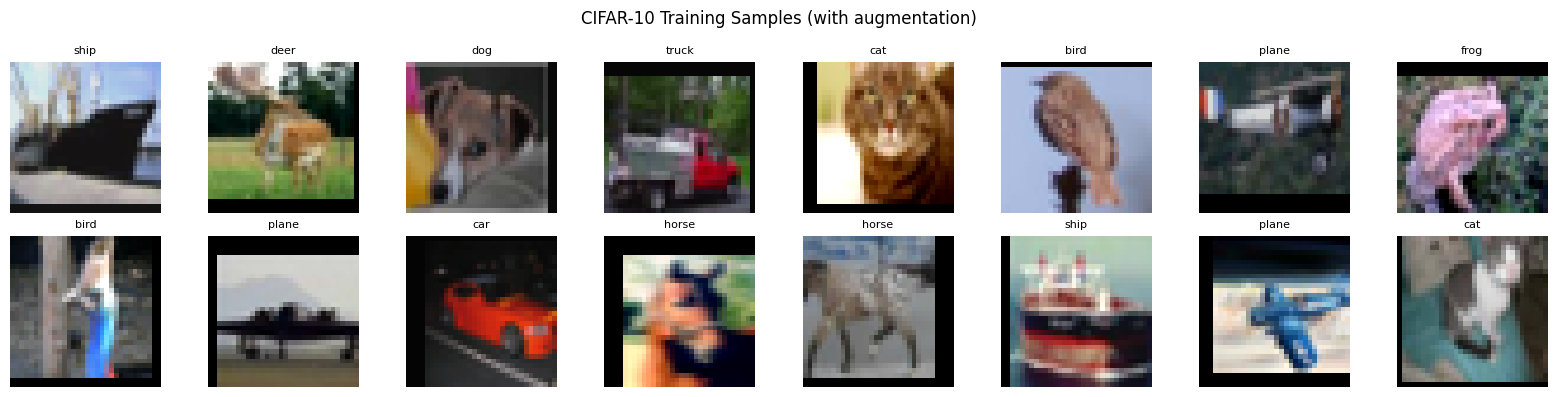

Saved cifar10_samples.png


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def denormalize(tensor):
    """Reverse normalization for visualization."""
    mean = torch.tensor(MEAN).view(3, 1, 1)
    std  = torch.tensor(STD).view(3, 1, 1)
    return torch.clamp(tensor * std + mean, 0, 1)

# Get one batch
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(CLASSES[labels[i]], fontsize=8)
    ax.axis('off')

plt.suptitle('CIFAR-10 Training Samples (with augmentation)', fontsize=12)
plt.tight_layout()
plt.savefig('cifar10_samples.png', dpi=100, bbox_inches='tight')
plt.show()
print('Saved cifar10_samples.png')

## 7. Training Setup

In [6]:
import torch.optim as optim
import time

# Configuration
CONFIG = {
    'num_epochs':       50,
    'learning_rate':    0.1,
    'momentum':         0.9,
    'weight_decay':     5e-4,
    'lr_decay_epochs':  [20, 35, 45],   # Reduce LR by 10x at these epochs
    'lr_decay_factor':  0.1,
}

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    momentum=CONFIG['momentum'],
    weight_decay=CONFIG['weight_decay'],
)

# MultiStepLR reduces LR by factor at specified epochs
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=CONFIG['lr_decay_epochs'],
    gamma=CONFIG['lr_decay_factor'],
)

print('Training configuration:')
for k, v in CONFIG.items():
    print(f'  {k}: {v}')

Training configuration:
  num_epochs: 50
  learning_rate: 0.1
  momentum: 0.9
  weight_decay: 0.0005
  lr_decay_epochs: [20, 35, 45]
  lr_decay_factor: 0.1


## 8. Training Loop

In [7]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss    = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total   += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(loader), correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs    = model(inputs)
            loss       = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total   += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(loader), correct / total


# Training history
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'lr': []}
best_test_acc = 0.0
total_start   = time.time()

print('=' * 65)
print(f'{"Epoch":<8} {"Train Loss":<12} {"Train Acc":<12} {"Test Loss":<12} {"Test Acc":<12} {"LR":<8}')
print('=' * 65)

for epoch in range(1, CONFIG['num_epochs'] + 1):
    epoch_start = time.time()

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss,  test_acc  = evaluate(model, test_loader, criterion, device)

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best_resnet18_cifar10.pth')

    # Log history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['lr'].append(current_lr)

    epoch_time = time.time() - epoch_start
    target_hit = '✅' if test_acc >= 0.85 else ''

    print(f'{epoch:<8} {train_loss:<12.4f} {train_acc:<12.4f} {test_loss:<12.4f} {test_acc:<12.4f} {current_lr:<8.4f} {epoch_time:.0f}s {target_hit}')

total_time = time.time() - total_start
print('=' * 65)
print(f'Total time:    {total_time/60:.1f} minutes')
print(f'Best test acc: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)')
print(f'Target >85%:   {"✅ ACHIEVED" if best_test_acc > 0.85 else "❌ Not reached"}')

Epoch    Train Loss   Train Acc    Test Loss    Test Acc     LR      
1        2.1488       0.2174       1.6687       0.3593       0.1000   51s 
2        1.5958       0.4023       1.4060       0.4794       0.1000   52s 
3        1.2966       0.5257       1.3261       0.5353       0.1000   52s 
4        1.0453       0.6281       1.0350       0.6259       0.1000   52s 
5        0.8560       0.6997       0.7731       0.7258       0.1000   52s 
6        0.7099       0.7535       0.7935       0.7313       0.1000   52s 
7        0.6377       0.7796       0.7755       0.7473       0.1000   51s 
8        0.5815       0.8008       0.6605       0.7743       0.1000   52s 
9        0.5503       0.8125       0.5821       0.7965       0.1000   52s 
10       0.5178       0.8217       0.6781       0.7822       0.1000   51s 
11       0.4902       0.8339       0.7219       0.7574       0.1000   52s 
12       0.4808       0.8366       0.6902       0.7745       0.1000   52s 
13       0.4643       0.8419  

## 9. Save History to JSON

In [8]:
import json

with open('training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print('Saved training_history.json')
print(f'Final Results:')
print(f'  Train Acc: {history["train_acc"][-1]:.4f}')
print(f'  Test Acc:  {history["test_acc"][-1]:.4f}')
print(f'  Best Test: {best_test_acc:.4f}')

Saved training_history.json
Final Results:
  Train Acc: 0.9940
  Test Acc:  0.9338
  Best Test: 0.9343


## 10. Plot Training Curves

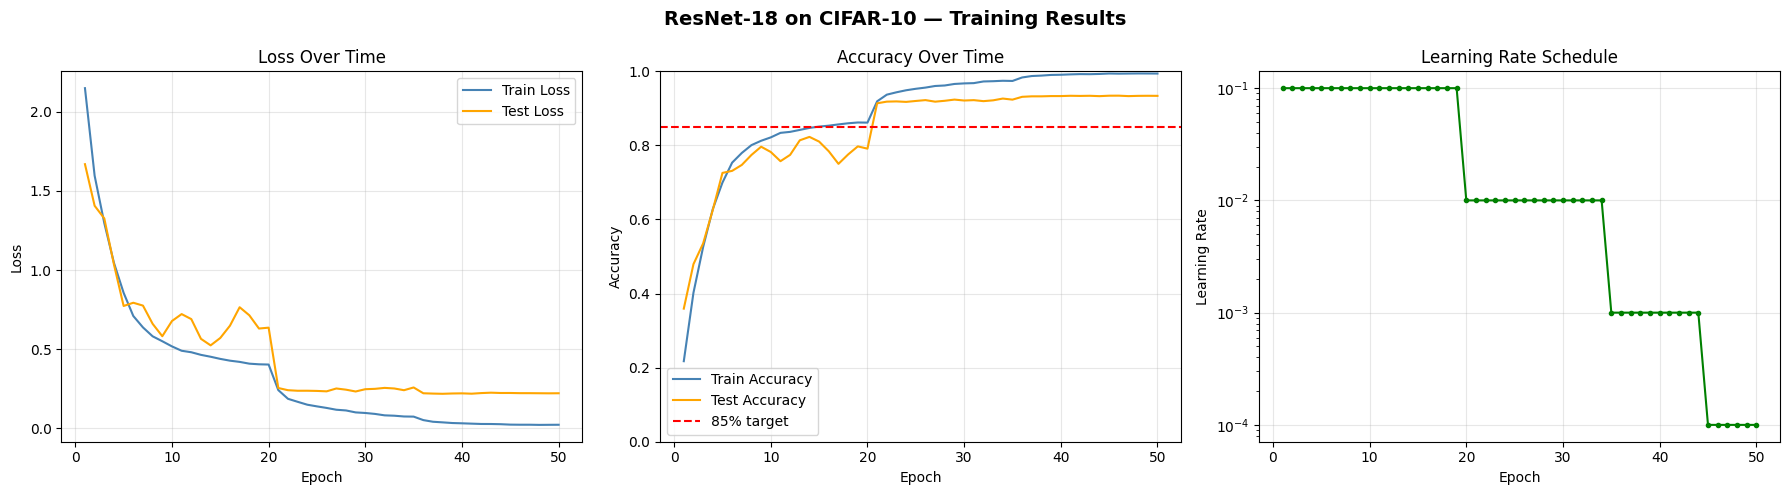

Saved resnet_cifar10_training.png


In [9]:
epochs = range(1, len(history['train_acc']) + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(epochs, history['train_loss'], label='Train Loss', color='steelblue')
axes[0].plot(epochs, history['test_loss'],  label='Test Loss',  color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, history['train_acc'], label='Train Accuracy', color='steelblue')
axes[1].plot(epochs, history['test_acc'],  label='Test Accuracy',  color='orange')
axes[1].axhline(y=0.85, color='red', linestyle='--', linewidth=1.5, label='85% target')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

# Learning rate
axes[2].plot(epochs, history['lr'], color='green', marker='o', markersize=3)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.suptitle('ResNet-18 on CIFAR-10 — Training Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('resnet_cifar10_training.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved resnet_cifar10_training.png')

## 11. Per-Class Accuracy

Per-Class Accuracy (Best Model: 93.43%)
----------------------------------------
plane   : 0.9450  ███████████████████████
car     : 0.9680  ████████████████████████
bird    : 0.9080  ██████████████████████
cat     : 0.8550  █████████████████████
deer    : 0.9470  ███████████████████████
dog     : 0.8980  ██████████████████████
frog    : 0.9500  ███████████████████████
horse   : 0.9510  ███████████████████████
ship    : 0.9610  ████████████████████████
truck   : 0.9600  ████████████████████████


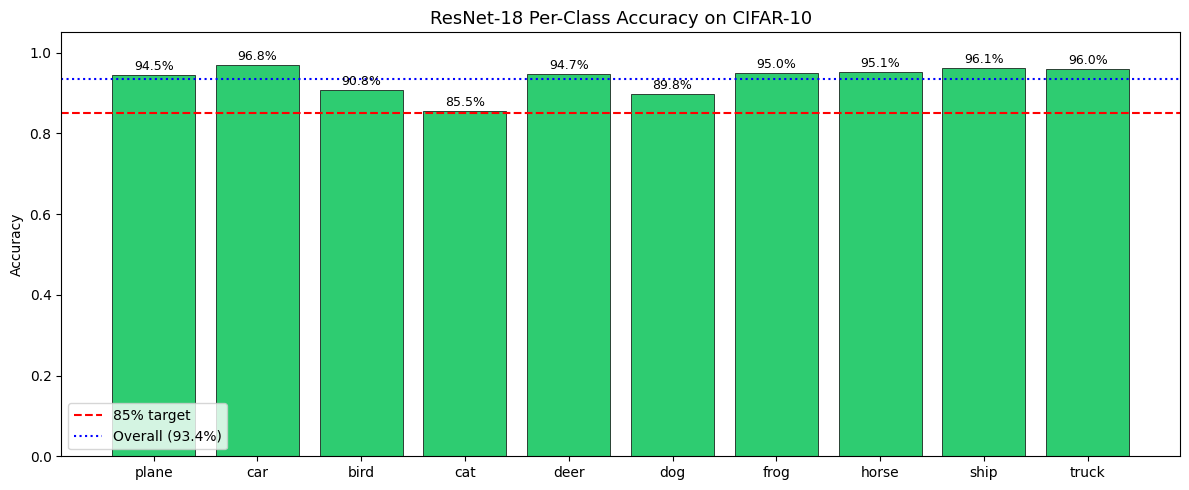

Saved resnet_per_class.png


In [10]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_resnet18_cifar10.pth'))
model.eval()

class_correct = [0] * 10
class_total   = [0] * 10

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs        = model(inputs)
        _, predicted   = torch.max(outputs, 1)

        for i in range(labels.size(0)):
            label = labels[i].item()
            class_correct[label] += (predicted[i] == labels[i]).item()
            class_total[label]   += 1

class_acc = [class_correct[i] / class_total[i] for i in range(10)]

# Print table
print(f'Per-Class Accuracy (Best Model: {best_test_acc*100:.2f}%)')
print('-' * 40)
for i, (cls, acc) in enumerate(zip(CLASSES, class_acc)):
    bar = '█' * int(acc * 25)
    print(f'{cls:<8}: {acc:.4f}  {bar}')

# Plot
colors = ['#2ecc71' if acc >= 0.85 else '#e74c3c' for acc in class_acc]

plt.figure(figsize=(12, 5))
bars = plt.bar(CLASSES, class_acc, color=colors, edgecolor='black', linewidth=0.5)
plt.axhline(y=0.85, color='red', linestyle='--', linewidth=1.5, label='85% target')
plt.axhline(y=best_test_acc, color='blue', linestyle=':', linewidth=1.5, label=f'Overall ({best_test_acc*100:.1f}%)')

for bar, acc in zip(bars, class_acc):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
             f'{acc:.1%}', ha='center', va='bottom', fontsize=9)

plt.title('ResNet-18 Per-Class Accuracy on CIFAR-10', fontsize=13)
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.savefig('resnet_per_class.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved resnet_per_class.png')

## 12. Visualize Predictions

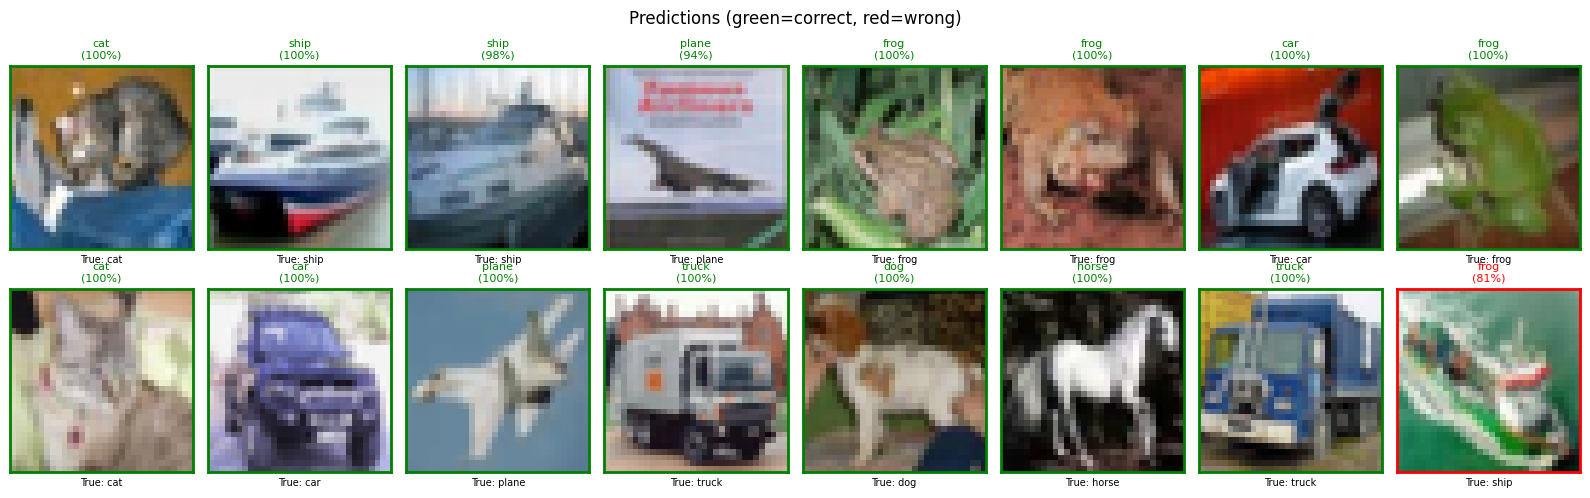

Saved resnet_predictions.png


In [11]:
model.eval()
images, labels = next(iter(test_loader))
images_gpu = images.to(device)

with torch.no_grad():
    outputs     = model(images_gpu)
    probs       = torch.softmax(outputs, dim=1)
    confidences, predictions = torch.max(probs, 1)

# Show first 16 samples
fig, axes = plt.subplots(2, 8, figsize=(16, 5))

for i, ax in enumerate(axes.flat):
    img        = denormalize(images[i]).permute(1, 2, 0).numpy()
    true_label = CLASSES[labels[i]]
    pred_label = CLASSES[predictions[i].item()]
    confidence = confidences[i].item()
    correct    = labels[i] == predictions[i].cpu()

    ax.imshow(img)
    color = 'green' if correct else 'red'
    ax.set_title(f'{pred_label}\n({confidence:.0%})', fontsize=8, color=color)
    ax.set_xlabel(f'True: {true_label}', fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(2)

plt.suptitle('Predictions (green=correct, red=wrong)', fontsize=12)
plt.tight_layout()
plt.savefig('resnet_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved resnet_predictions.png')

## 13. Final Results Summary

In [12]:
print('=' * 55)
print('FINAL RESULTS — ResNet-18 on CIFAR-10')
print('=' * 55)
print(f'  Best Test Accuracy:   {best_test_acc*100:.2f}%')
print(f'  Final Train Accuracy: {history["train_acc"][-1]*100:.2f}%')
print(f'  Final Test Accuracy:  {history["test_acc"][-1]*100:.2f}%')
print(f'  Total Epochs:         {CONFIG["num_epochs"]}')
print(f'  Training Time:        {total_time/60:.1f} minutes')
print(f'  Device:               {device}')
print(f'  Parameters:           {model.count_parameters():,}')
print()
print(f'  Target >85%:          {"✅ ACHIEVED" if best_test_acc > 0.85 else "❌ Not reached"}')
print()
print('Benchmark comparison:')
print(f'  Random guessing:      10.00%')
print(f'  This model (50ep):    {best_test_acc*100:.2f}%')
print(f'  Paper (100ep, GPU):   ~93.00%')
print(f'  State of the art:     ~99.00%')
print('=' * 55)

FINAL RESULTS — ResNet-18 on CIFAR-10
  Best Test Accuracy:   93.43%
  Final Train Accuracy: 99.40%
  Final Test Accuracy:  93.38%
  Total Epochs:         50
  Training Time:        42.9 minutes
  Device:               cuda
  Parameters:           11,173,962

  Target >85%:          ✅ ACHIEVED

Benchmark comparison:
  Random guessing:      10.00%
  This model (50ep):    93.43%
  Paper (100ep, GPU):   ~93.00%
  State of the art:     ~99.00%


## 14. Download Results

In [13]:
from google.colab import files

print('Downloading files...')

# Model weights
files.download('best_resnet18_cifar10.pth')

# Training history
files.download('training_history.json')

# Plots
files.download('resnet_cifar10_training.png')
files.download('resnet_per_class.png')
files.download('resnet_predictions.png')
files.download('cifar10_samples.png')

print('All files downloaded!')
print()
print('Next steps:')
print('  1. Move .png files to computer-vision-foundations/code/pytorch_cnn/outputs/')
print('  2. Move .pth and .json to computer-vision-foundations/code/pytorch_cnn/')
print('  3. git add . && git commit -m "ResNet-18 CIFAR-10 results" && git push')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All files downloaded!

Next steps:
  1. Move .png files to week-01/code/pytorch_cnn/outputs/
  2. Move .pth and .json to week-01/code/pytorch_cnn/
  3. git add . && git commit -m "ResNet-18 CIFAR-10 results" && git push
